# Probabilities of recombination

In [1]:
from __future__ import division, print_function
from IPython.display import display, HTML, Math, Latex
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import log, sqrt, factorial
from scipy import stats, optimize

## gDNA sequences

The two graph below are showing the allowed value of $p_r$ and $p_r^{\prime}$, computed using the gdna data.

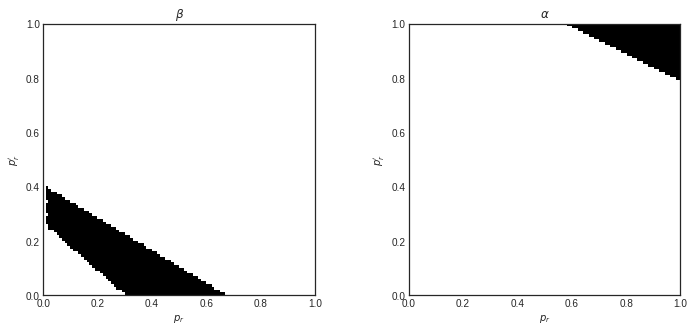

In [2]:
def pf(pr, prp, pc, p_nc_obs):
    return 1./(2.*pc*pr + 1e-8)*(2*pr+1+prp - (pr+prp)*(1-pc)*(1./p_nc_obs))

def p_prod_possible(pc, p_out_observed, err):
    n_grid = 100 # increase for better precision
    img = np.zeros((n_grid,n_grid))
    img.fill(float(0))
    for k in range(n_grid):
        for l in range(n_grid):
            # taking into account the error bar
            for p_out in np.arange(p_out_observed - err,
                                   p_out_observed + err,
                                  1e-3):
                p = pf(l/n_grid, k/n_grid, pc, p_out)
                if p <= 1. and p >= 0.:
                    img[n_grid - 1 - k, l] = 1
                    break
    return img


pc_a = 1 - 2/3 - 0.028
pc_b = 1 - 2/3 - 0.0678

with plt.style.context("seaborn-white"):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 5))
    img_beta = p_prod_possible(pc_b, 0.18, 0.03)
    img_alpha = p_prod_possible(pc_a, 0.40, 0.01)

    ax1.imshow(img_beta, extent=(0,1,0,1))
    ax2.imshow(img_alpha, extent=(0,1,0,1))
    ax1.grid(False)
    ax2.grid(False)
    ax1.set_title(r"$\beta$")
    ax1.set_xlabel(r"$p_r$")
    ax1.set_ylabel(r"$p_r^{\prime}$")

    ax2.set_title(r"$\alpha$")
    ax2.set_xlabel(r"$p_r$")
    ax2.set_ylabel(r"$p_r^{\prime}$")
    plt.savefig("gdna_results.pdf")
    plt.show()

## RNA sequences

This notebook details the fits associated with the figure S3.

In [3]:
# Experiment selection : 
experiment="exp3"

In [6]:
filepairsab = "../Datas/"+experiment+"/pairs_ab.tsv.gz"
filepairsaa = "../Datas/"+experiment+"/pairs_aa.tsv.gz"
filepairsbb = "../Datas/"+experiment+"/pairs_bb.tsv.gz"

In [7]:
N = 1000
Nmin = 10
dfaa = pd.read_csv(filepairsaa, sep="\t")
dfaa = dfaa[(dfaa.nb_wells_1 > 5) & (dfaa.nb_wells_2 > 5) & 
               (dfaa.nb_wells_1 < 70) & (dfaa.nb_wells_2 < 70) &
               (dfaa.distance > 20)]
dfaa[dfaa.distance >= 20]
df = dfaa

Nmin = 10
N=1000
nbbins = 20
vOut = np.concatenate((df[df.status_2 == "Out"].copy_2.values,
                       df[df.status_1 == "Out"].copy_1.values))

hOut = np.histogram(vOut, bins=nbbins, range=(Nmin,N), density=True)[0]
vE = df[df.status_2 == "Out"].copy_1.values
hE = np.histogram(vE, bins=nbbins, range=(Nmin,N), density=True)[0]
vInin = np.concatenate((df[(df.status_1 == "In") & (df.status_2 == "In")].copy_1.values,
                       df[(df.status_1 == "In") & (df.status_2 == "In")].copy_2.values))
hInin = np.histogram(vInin, bins=nbbins, range=(Nmin,N), density=True)[0]


print("length ; vOut : ", len(vOut), ",  vE : ", len(vE), ",  vInin : ", len(vInin))

mini = 1e12
best = (-1, -1)
for p in np.arange(0.,1.,0.01):
    tot = sum([(aIn - p*aOut - (1-p)*aE)**2 for (aIn, aOut, aE)
            in zip(hInin, hOut, hE)])
    if(tot < mini):
        best = (p, 1-p)
        mini = tot

nplin = np.linspace(Nmin,N,nbbins)
fitres = best[0]*hOut + best[1]*hE
p = best[0]
propEE = 1 - 2*p
pm10 = p - 10/100
pp10 = p + 10/100 

print("Proportion of exposed-exposed cells: ", propEE)
print("Best fit: ", best)

hOut = np.histogram(vOut, bins=nbbins, range=(Nmin,N), density=True)[0]
hE = np.histogram(vE, bins=nbbins, range=(Nmin,N), density=True)[0]
hInin = np.histogram(vInin, bins=nbbins, range=(Nmin,N), density=True)[0]
fitresm10 = pm10*hOut + (1-pm10)*hE
fitresp10 = pp10*hOut + (1-pp10)*hE
fitres = p*hOut + (1-p)*hE
nplin = np.linspace(Nmin,N,nbbins)


length ; vOut :  23433 ,  vE :  11740 ,  vInin :  35236
Proportion of exposed-exposed cells:  0.4
Best fit:  (0.3, 0.7)


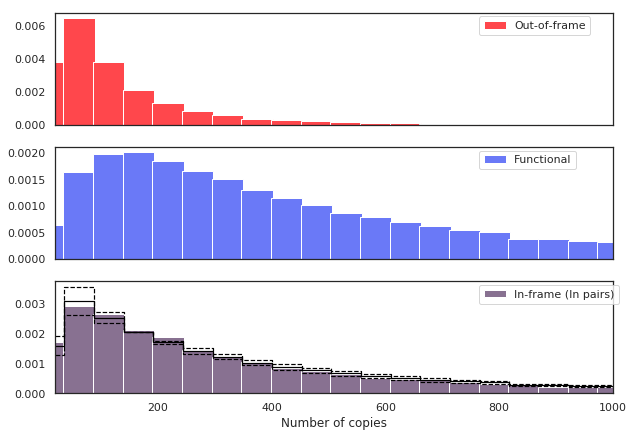

In [8]:
sns.set(palette="deep", style="white")
f, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 7), sharex=True)

ax1.bar(nplin, hOut, label="Out-of-frame",
                 color='xkcd:light red', alpha=1, width=N/nbbins*1.1)

ax2.bar(nplin, hE, label="Functional", 
                 color='xkcd:cornflower', alpha=1, width=(N/nbbins)*1.1)


ax3.bar(nplin,hInin, label="In-frame (In pairs)",
                 color='xkcd:greyish purple', alpha=1, width=(N/nbbins)*1.1)
ax3.step(nplin,fitresm10, 
             linewidth=1.2, color='xkcd:black', where='mid',linestyle='dashed')
ax3.step(nplin,fitresp10, 
            linewidth=1.2, color='xkcd:black', where='mid',linestyle='dashed')
ax3.step(nplin,fitres, 
             linewidth=1.2, color='xkcd:black', where='mid')

ax1.set(xlim=(Nmin, N), xlabel="")
ax1.legend(loc=(0.76,0.8))
ax2.set(xlim=(Nmin, N-10), xlabel="")
ax2.legend(loc=(0.76,0.8))
ax3.set(xlim=(Nmin, N-N/nbbins), xlabel="Number of copies")
ax3.legend(loc=(0.76,0.8))
plt.xlim([20,1000])
plt.show()
